In [ ]:
pip install torch torchvision matplotlib numpy tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision.utils as vutils

from torch.utils.data import DataLoader, Dataset

import numpy as np
import os
from tqdm import tqdm
from PIL import Image


In [ ]:
class MalimgDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.classes = sorted([
            d for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for img_file in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_file)
                if os.path.isfile(img_path):
                    self.image_paths.append(img_path)
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = T.Compose([
            transform,
            T.ToTensor()  # <-- Apply ToTensor here only
        ])

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        img1 = self.transform(img)
        img2 = self.transform(img)
        return img1, img2

    def __len__(self):
        return len(self.dataset)


In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.5, 0.5, 0.5, 0.5),
    T.RandomGrayscale(p=0.2),
])

malimg_path = '/content/drive/MyDrive/malimg_paper_dataset_imgs'  # <-- Change to your actual path
malimg_dataset = MalimgDataset(root_dir=malimg_path, transform=transform)
contrastive_dataset = ContrastiveDataset(malimg_dataset, transform)
train_loader = DataLoader(contrastive_dataset, batch_size=32, shuffle=True)


In [ ]:
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = base_model
        self.encoder.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections

model = SimCLR(models.resnet50(pretrained=False))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    z = F.normalize(z, dim=1)

    similarity = torch.matmul(z, z.T) / temperature
    labels = torch.arange(batch_size).to(z.device)
    labels = torch.cat([labels, labels], dim=0)

    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(z.device)
    similarity = similarity.masked_fill(mask, -9e15)

    positives = torch.diag(similarity, batch_size) + torch.diag(similarity, -batch_size)
    numerator = torch.exp(positives)

    mask_positives = torch.eye(batch_size * 2, dtype=torch.bool).to(z.device)
    for i in range(batch_size):
        mask_positives[i, batch_size + i] = True
        mask_positives[batch_size + i, i] = True

    denominator = torch.exp(similarity).masked_fill(mask_positives, 0).sum(dim=1)
    numerator = numerator.repeat(2)
    denominator = denominator + numerator
    loss = -torch.log(numerator / denominator).mean()
    return loss


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")


Device: cuda


In [10]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
save_dir = '/content/drive/MyDrive/SimCLR_Malimage'
pretext_losses = []
for epoch in range(20):
    model.train()
    total_loss = 0
    for img1, img2 in tqdm(train_loader):
        img1, img2 = img1.to(device), img2.to(device)
        z1 = model(img1)
        z2 = model(img2)
        loss = nt_xent_loss(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    pretext_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}] Pretext Loss: {avg_loss}")
    model_path = os.path.join(save_dir, f'simclr_pretask_resnet50.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")


100%|██████████| 293/293 [1:55:06<00:00, 23.57s/it]


Epoch [1] Pretext Loss: 2.2380844492961116
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:38<00:00,  1.85it/s]


Epoch [2] Pretext Loss: 2.237521557677728
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:41<00:00,  1.81it/s]


Epoch [3] Pretext Loss: 2.237434316820659
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.83it/s]


Epoch [4] Pretext Loss: 2.238415312034685
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:39<00:00,  1.83it/s]


Epoch [5] Pretext Loss: 2.237433381861794
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.83it/s]


Epoch [6] Pretext Loss: 2.237432400521158
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.83it/s]


Epoch [7] Pretext Loss: 2.237430821913501
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.83it/s]


Epoch [8] Pretext Loss: 2.062498992213617
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.82it/s]


Epoch [9] Pretext Loss: 1.4925450239165243
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.82it/s]


Epoch [10] Pretext Loss: 1.1540701360832708
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.82it/s]


Epoch [11] Pretext Loss: 1.0756633523788062
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.82it/s]


Epoch [12] Pretext Loss: 1.0359270397713567
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.82it/s]


Epoch [13] Pretext Loss: 0.991261370963204
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.83it/s]


Epoch [14] Pretext Loss: 0.9631981217006774
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.82it/s]


Epoch [15] Pretext Loss: 0.9403242222685049
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:41<00:00,  1.81it/s]


Epoch [16] Pretext Loss: 0.928190559047074
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.82it/s]


Epoch [17] Pretext Loss: 0.9121675182121198
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:40<00:00,  1.82it/s]


Epoch [18] Pretext Loss: 0.9034377004913096
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:41<00:00,  1.82it/s]


Epoch [19] Pretext Loss: 0.8928291013419831
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


100%|██████████| 293/293 [02:41<00:00,  1.82it/s]


Epoch [20] Pretext Loss: 0.8848247268704424
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_pretask_resnet50.pth


In [14]:
save_dir = '/content/drive/MyDrive/SimCLR_Malimage'
model_path = os.path.join(save_dir, 'simclr_pretask_resnet50.pth')
model.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

In [18]:
for param in model.encoder.parameters():
    param.requires_grad = False

classifier = nn.Linear(2048, len(malimg_dataset.classes)).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [19]:
# Reuse MalimgDataset with basic transform
basic_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
labeled_dataset = MalimgDataset(root_dir=malimg_path, transform=basic_transform)
labeled_loader = DataLoader(labeled_dataset, batch_size=256, shuffle=True)


In [20]:
downstream_losses = []
downstream_accuracies = []

for epoch in range(20):
    classifier.train()
    total_loss = 0
    correct, total = 0, 0
    for imgs, labels in tqdm(labeled_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        features = model.encoder(imgs)
        logits = classifier(features)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    downstream_losses.append(total_loss / len(labeled_loader))
    downstream_accuracies.append((correct / total) * 100)
    print(f"Classifier Epoch [{epoch+1}] Loss: {total_loss / len(labeled_loader)}, Accuracy: {correct / total * 100:.2f}%")
    model_path = os.path.join(save_dir, f'simclr_malware_classification.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")


100%|██████████| 37/37 [01:00<00:00,  1.64s/it]


Classifier Epoch [1] Loss: 1.0401768611895073, Accuracy: 72.13%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:00<00:00,  1.63s/it]


Classifier Epoch [2] Loss: 0.5043520862991745, Accuracy: 84.81%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [3] Loss: 0.44390546550621857, Accuracy: 86.99%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.65s/it]


Classifier Epoch [4] Loss: 0.40109511243330465, Accuracy: 88.10%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [5] Loss: 0.37502524699713735, Accuracy: 88.42%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [6] Loss: 0.3561692491576478, Accuracy: 89.75%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.65s/it]


Classifier Epoch [7] Loss: 0.3364103275376397, Accuracy: 90.05%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [8] Loss: 0.31620234734303243, Accuracy: 90.85%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [9] Loss: 0.30758419874552134, Accuracy: 91.16%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [10] Loss: 0.29443989210837596, Accuracy: 91.61%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [11] Loss: 0.3056556167634758, Accuracy: 91.42%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.65s/it]


Classifier Epoch [12] Loss: 0.2838592654144442, Accuracy: 91.70%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [13] Loss: 0.2797758188602087, Accuracy: 91.51%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [14] Loss: 0.260353427883741, Accuracy: 92.39%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [15] Loss: 0.262071164878639, Accuracy: 92.50%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [16] Loss: 0.2496102540879636, Accuracy: 92.73%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.65s/it]


Classifier Epoch [17] Loss: 0.2523534430845364, Accuracy: 92.62%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.65s/it]


Classifier Epoch [18] Loss: 0.24839041160570607, Accuracy: 93.00%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.65s/it]


Classifier Epoch [19] Loss: 0.25469451176153646, Accuracy: 92.99%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


100%|██████████| 37/37 [01:01<00:00,  1.66s/it]


Classifier Epoch [20] Loss: 0.2372132406846897, Accuracy: 93.25%
Model saved to /content/drive/MyDrive/SimCLR_Malimage/simclr_malware_classification.pth


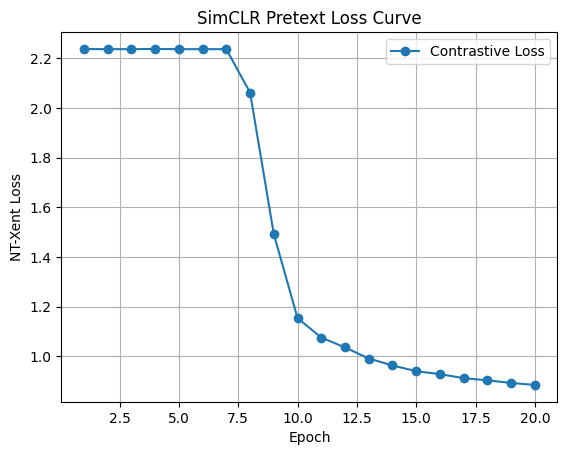

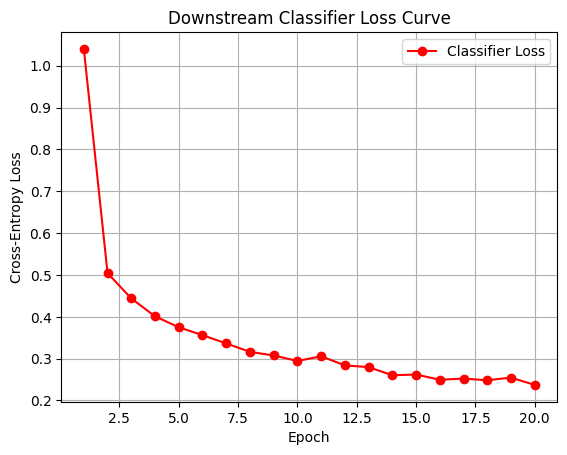

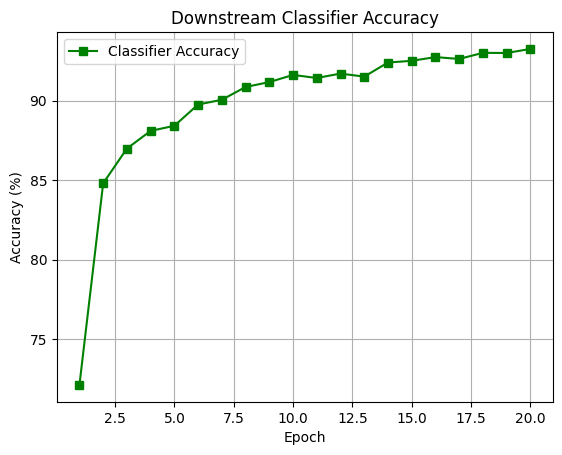

In [21]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(pretext_losses) + 1), pretext_losses, marker='o', label='Contrastive Loss')
plt.title('SimCLR Pretext Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('NT-Xent Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1, len(downstream_losses) + 1), downstream_losses, marker='o', color='red', label='Classifier Loss')
plt.title('Downstream Classifier Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1, len(downstream_accuracies) + 1), downstream_accuracies, marker='s', color='green', label='Classifier Accuracy')
plt.title('Downstream Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()


In [22]:
from sklearn.metrics import classification_report, accuracy_score

test_dataset = MalimgDataset(root_dir=malimg_path, transform=basic_transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

all_preds, all_labels = [], []
classifier.eval()
model.encoder.eval()

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        features = model.encoder(imgs)
        logits = classifier(features)
        preds = logits.argmax(dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))
print("Test Accuracy: {:.2f}%".format(accuracy_score(all_labels, all_preds) * 100))


                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00       122
     Agent.FYI       1.00      1.00      1.00       116
     Allaple.A       0.95      1.00      0.97      2949
     Allaple.L       1.00      0.95      0.97      1601
 Alueron.gen!J       0.90      0.96      0.93       198
     Autorun.K       0.00      0.00      0.00       106
       C2LOP.P       0.67      0.51      0.58       146
   C2LOP.gen!g       0.61      0.81      0.69       200
Dialplatform.B       0.99      0.98      0.98       177
     Dontovo.A       0.99      1.00      0.99       162
      Fakerean       0.99      0.98      0.99       381
 Instantaccess       1.00      1.00      1.00       431
    Lolyda.AA1       0.84      0.94      0.89       213
    Lolyda.AA2       0.97      0.83      0.89       184
    Lolyda.AA3       0.90      0.98      0.93       123
     Lolyda.AT       1.00      0.97      0.99       159
   Malex.gen!J       0.98      0.74      0.85  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


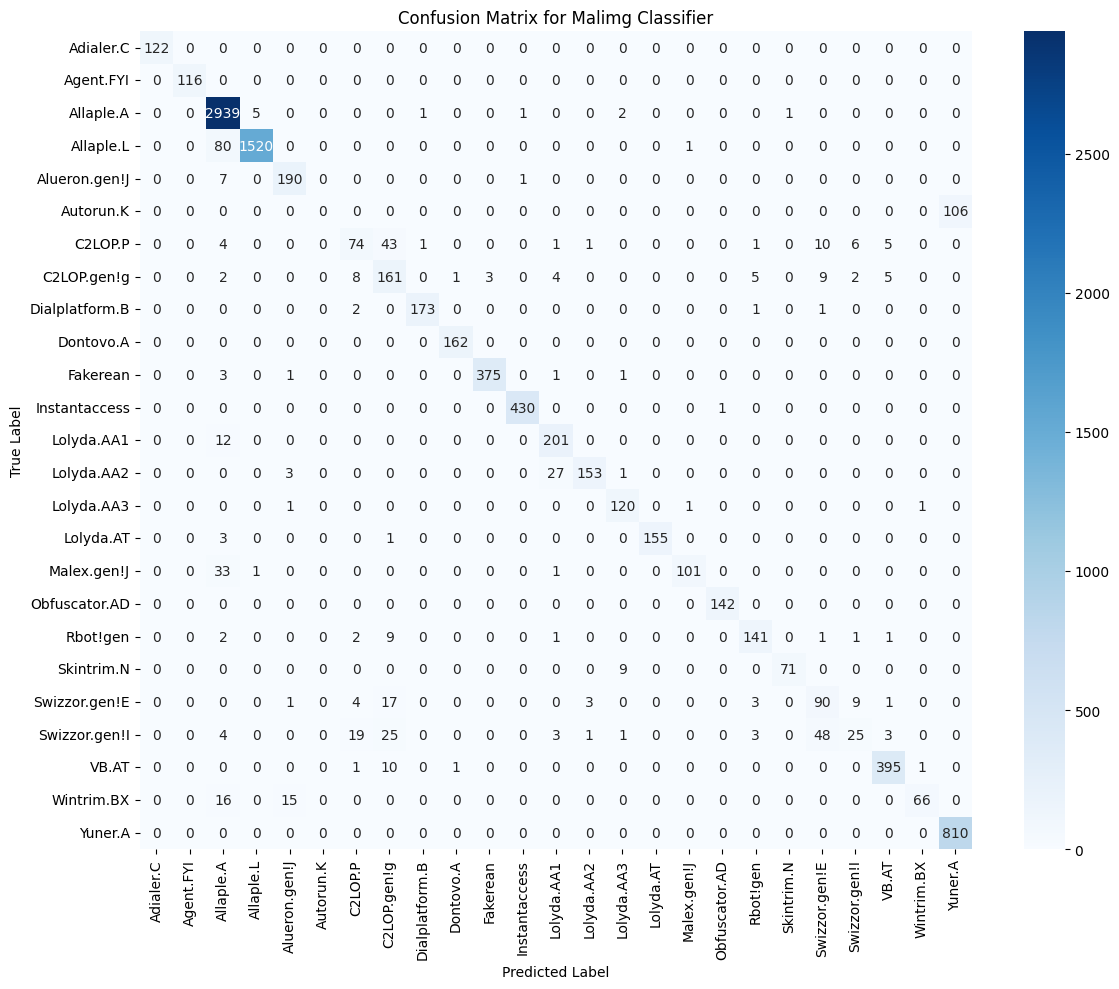

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get class names
class_names = test_dataset.classes

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix for Malimg Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
